In [22]:
import matplotlib.pyplot as plt
import numpy as np
import mcu
import data
from importlib import reload

In [23]:
reload(data)
reload(mcu)

np.random.seed(179)
control_vars = data.get_control_vars(data.get_p())
response_matrix = data.generate_array_of_swiss_rolls(control_vars)
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, response_matrix)
q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges)

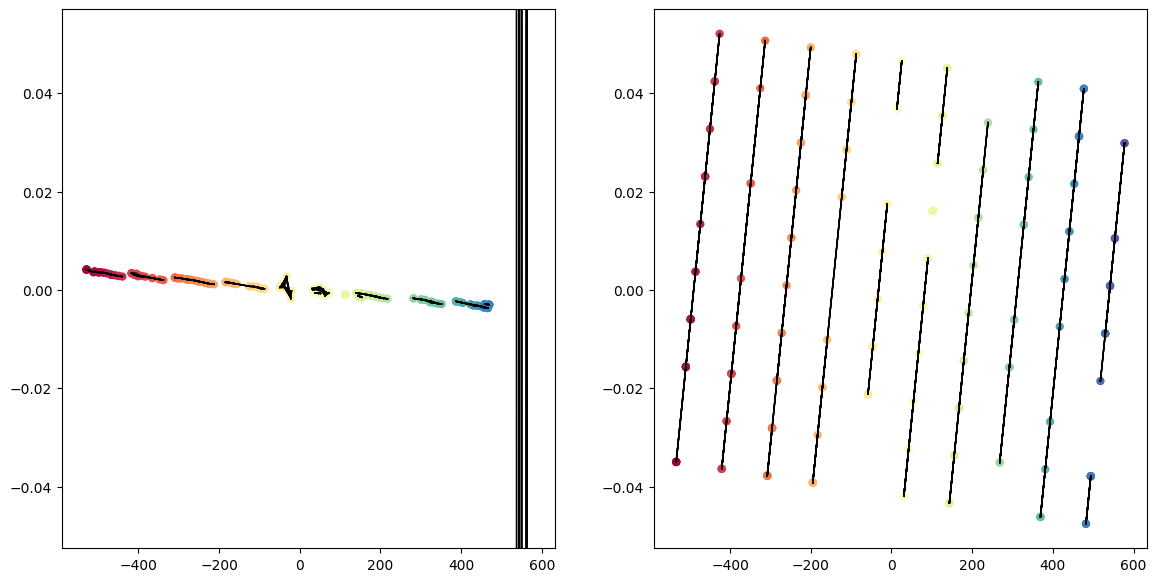

In [24]:
reload(mcu)
m_ = control_vars.shape[1]
# m_ = get_optimal_dimensionality(s)
ld_embedding = mcu.reduce_dimensions(q, m_)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

# rre = mcu.compute_rre(ld_embedding, reconstructed_y)
# mcu.plot_rre_heatmap(rre, reconstructed_y)
# print(np.median(rre))
mcu.plot_two_embeddings_with_edges(ld_embedding, reconstructed_y, edges)
# print(np.sort(np.abs(mcu.diff_of_edges_lengths(ld_embedding, centered_y, edges)))[::-1])
# mcu.plot_two_embeddings(ld_embedding, reconstructed_y)

In [4]:
reload(data)
reload(mcu)

n_of_tests = 100
test_control_vars = data.get_control_vars(data.get_p(), n_of_tests)
test_rolls = data.generate_array_of_swiss_rolls(test_control_vars, n_of_tests)
x_opts = []
for (roll, control_var) in zip(test_rolls, test_control_vars):
    x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler)
    x_opt = x_opt * x_stds + x_means
    x_opts.append(x_opt)
    print("-----------")
    print(f"x_opt  = {x_opt}, x_err = {x_err}")
    print(f"x_real = {control_var}")

x_ops = np.array(x_opts)
test_control_vars = np.array(test_control_vars)

-----------
x_opt  = [8.81524665 7.17424079], x_err = 2.3560495205274073e-14
x_real = [3 7]
-----------
x_opt  = [5.67186709 8.7928593 ], x_err = 3.659590551943711e-12
x_real = [9 8]
-----------
x_opt  = [5.10733028 7.60759641], x_err = 7.673571615119793e-12
x_real = [8 9]
-----------
x_opt  = [2.73713083 2.69718492], x_err = 1.4724403260661307e-12
x_real = [10  3]
-----------
x_opt  = [6.82176711 1.7557648 ], x_err = 6.935615171376618e-13
x_real = [8 1]
-----------
x_opt  = [5.12561582 7.95358995], x_err = 3.0838637867603264e-13
x_real = [8 7]
-----------
x_opt  = [6.50123896 1.79669442], x_err = 8.334361163039131e-12
x_real = [8 1]
-----------
x_opt  = [1.77325237 6.28769171], x_err = 3.1945781566206943e-13
x_real = [6 7]
-----------
x_opt  = [8.63158788 4.99283472], x_err = 7.76418661399664e-12
x_real = [5 5]
-----------
x_opt  = [3.56509957 2.21638555], x_err = 7.500551339775747e-13
x_real = [7 3]
-----------
x_opt  = [6.19634017 7.6224092 ], x_err = 1.0278381707714644e-11
x_real =

[5.81785643 3.4212709  3.21034669 7.26917915 1.39979041 3.02843495
 1.69735284 4.28634793 3.63159495 3.52315094 0.65264283 7.44392031
 1.37210413 2.46620342 2.65065043 3.37386336 4.02331935 1.51965134
 1.13630992 5.12121925 2.72018903 2.17125218 2.7429994  0.71413813
 3.1719886  3.0582477  4.5679358  2.13780714 2.77282932 0.74231683
 1.80186666 3.75854986 1.009856   2.07335518 7.51043585 1.53746154
 1.70763396 2.732331   2.52484817 3.46912682 1.67644962 2.03245078
 1.91527249 2.50448947 2.01173538 7.45603456 6.37654545 1.91025521
 4.01850234 0.59639408 1.50029738 4.15628438 1.96985977 5.13826002
 1.60744207 6.60799272 3.89302946 4.36046576 6.20478931 1.84795657
 2.04245489 5.33485579 5.03679113 4.79894703 5.16072202 4.90008944
 3.25289948 1.17628181 3.87171511 5.12919401 3.25880671 7.37905134
 2.64952752 3.13081875 3.71441881 1.5519825  7.09940337 5.64478512
 6.19508868 5.96087968 2.61793461 0.92184353 0.92921866 6.04282792
 1.70060174 1.01140187 5.80150827 2.27712769 3.38645038 6.7050

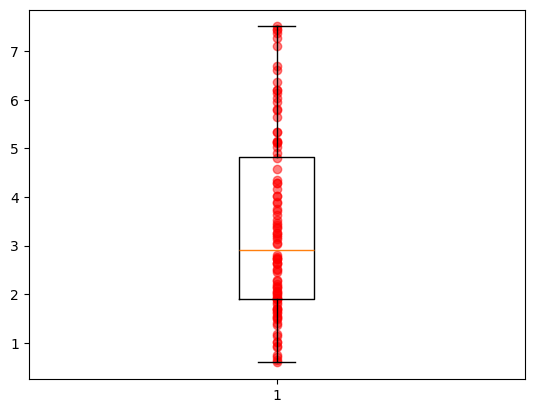

In [5]:
errors = np.linalg.norm(x_opts - test_control_vars, axis = 1)
plt.boxplot(errors)
plt.scatter(np.ones_like(errors), errors, alpha=0.5, color='red')
print(errors)
print(f"Median of errors = {np.median(errors)}")